# Passive Network Measurement

Network operators look at different types of network traffic data to understand properties of their networks. Some network data can be collected directly from network devices (e.g., routers, switches) while they are forwarding live traffic.  Collecting this data does not affect network behavior and is therefore called "passive" (as opposed to "active" measurements).

In this section, we will analyze traffic volumes - a type of passive network measurement data.

## Background

### Traffic Measurement with IPFIX

Routers in most networks collect traffic measurements using the [IPFIX protocol](https://en.wikipedia.org/wiki/IP_Flow_Information_Export). [NetFlow](https://en.wikipedia.org/wiki/NetFlow), a proprietary form of IPFIX defined by Cisco, is well-known in the networks community because Cisco supplies routers for many large networks.

In this section, we'll analyze a trace of NetFlow records captured from a router that connects Princeton University's campus network to the Internet. The section will perform similar kinds of analysis that a network operator would perform -- asking questions about the most popular endpoints for the campus traffic, the most popular web applications, and so forth (As you can imagine, when we start to think about security, the ability to analyze these baselines will come in handy!).

The flow records are in the file `netflow.csv`.  To simplify the analysis, we have ensured that the IP addresses of the campus network start with `128.112` and have their 16 lower bits anonymized to protect the privacy of users. To further simplify your task, we have parsed these records into CSV (comma-separated variable) format, with the names of the fields listed in the first row of the file. (In a real network, routers export IPFIX records as binary files)

### Functional data analysis with map() and reduce()

Several of the data analysis steps in this section use a "MapReduce" programming model. MapReduce originated in functional programming languages and involves using two functions (called `map()` and `reduce()`...surprise!) to apply functions to iterable data (like linked-lists, arrays, etc.). 

##### map()

A general `map()` function has two arguments: another function (which itself takes one argument) and an iterable object. `map()` then applies (maps) the argument function to every item in the iterable object. See [the documentation](https://docs.python.org/3/library/functions.html#map) of Python's built-in `map()` function for more details. The following toy example uses `map()` to add 3 to every element of a list

In [1]:
some_numbers = [1,2,3]
three_more = map(lambda x: x+3, some_numbers)
print(list(three_more))

[4, 5, 6]


`map()` is often used with the anonymous function (the `lambda` in the above example), but can be used just as easily with normal functions:

In [2]:
def add3(i):
    return i+3
 
some_numbers = [1,2,3]
three_more = map(add3, some_numbers)
print(list(three_more))

[4, 5, 6]


##### reduce()

A general `reduce()` function takes another function (which itself takes *two* values), an iterable object, and an optional initializer value. It apples the function of two arguments cumulatively to the items of the iterable object, from left to right, so as to reduce the sequence to a single value. This allows `reduce()` to compute summaries over all data in the iterable object. See [the documentation](https://docs.python.org/3/library/functools.html#functools.reduce) of Python `functools`'s `reduce()` function for more details. The following example uses `reduce()` to count the number of 4s in a list of integers:

In [3]:
from functools import reduce

def count_4s(count, i):
    # The order of the arguments matters. 
    #     The first argument is the accumulated value
    #     The secod argument is next value from the iterable
    if i == 4:
        return count + 1
    else:
        return count

some_numbers = [1,4,0,1,4]
num_fours = reduce(count_4s, some_numbers, 0) # 0 is the initializer value 
print(num_fours)

2


[MapReduce](https://en.wikipedia.org/wiki/MapReduce) is popular because it allows analysis tasks on large data sets to be easily parallelized .  Although there are many open-source and proprietary MapReduce-style data processing libraries (typically with different ways of expressing iterable datasets and distributing tasks over many computers), they all involve `map()` and `reduce()` functions like you will use in this assignment.

### Parse IPFIX Data
The `netflow.csv` file contains some pre-processed netflow data. The data is "unsampled," i.e. it compiles flow statistics for every packet that traverses any interface on the border router.  We used the `nfdump` tool to process the raw NetFlow data that the router collected. Each row of the `netflow.csv` file, except for the header on top, logs the following information for a flow:

```
Date first seen, Time first seen (m:s), Date last seen, Time last seen (m:s), Duration (s), Protocol, 
Src IP addr, Src port, Dst IP addr, Dst port, Packets, Bytes, Flags, Input interface, Output interface		

```

To analyze this data, we first need to read it into a python data structure.  The following code uses the built-in `csv` library to read `netflow.csv` into a list of dictionaries.  The `csv` library documentation is [here](https://docs.python.org/3/library/csv.html).

In [4]:
import csv

with open('netflow.csv', 'r') as netflow_file:
    netflow_reader = csv.DictReader(netflow_file)
    netflow_data = list(netflow_reader)
    
print("Number of flow records: {}".format(len(netflow_data)))
print("Sample flow record: {}".format(netflow_data[0]))

Number of flow records: 105360
Sample flow record: {'Date first seen': '10/29/15', 'Time first seen (m:s)': '04:48.9', 'Date last seen': '10/29/15', 'Time last seen (m:s)': '04:48.9', 'Duration (s)': '0', 'Protocol': 'ICMP', 'Src IP addr': '172.16.241.1', 'Src port': '0', 'Dst IP addr': '128.112.213.189', 'Dst port': '11', 'Packets': '1', 'Bytes': '94', 'Flags': '.A....', 'Input interface': '120', 'Output interface': '0'}


### Analyze IPFIX Data

The following sections each focus on answering a specific question using the netflow data you have prepared. These questions are both of interest to real network operators and might reveal some surprising facts about how the campus community uses the Internet.  

#### What are the most popular IP addresses accessed by the users?

In order to answer this question, we have to decide how to measure IP address popularity. Total traffic volume across all flows seems like a reasonable option, but so does total number of flows to an IP address regardless of volume.  Network operaters actually use both metrics (among others), which we will do here as well.  

*Step 1: Determine popular IP addresses by number of flows*

The following code to produce a python dictionary `ips_by_flows` with counts of the total number of flows to each external (not 128.112.\*.\*) IP address in `netflow_data`.  The keys of the dict are the IP addresses and the values are the integer flow counts.

The `count_by_flows()` function, which takes an existing dict of the form described above and updates it appropriately from `current_flow`.  If you are confused about datatypes, use print statements to inspect variables. 

The helper function `test_internal` tests if an IP address starts with `128.112`.

Then, the `reduce()` function builds a dictionary result.  The initializer argument to `reduce()` is `defaultdict(int)`. The [defaultdict()](https://docs.python.org/3/library/collections.html#collections.defaultdict) function creates a dictionary with default values that are the output of the argument function (in this case, just 0). This allows you to increment the value of a particular key without first checking to see if the key is already in the dictionary (if you used `{}` to create the dict instead of `defaultdict()`, this would raise a KeyError).

The provided code will print and plot the most popular IPs.

Most popular IP addresses by number of flows: [('116.211.0.90', 17015), ('169.54.233.126', 9424), ('163.53.247.3', 2981), ('169.45.161.189', 2494), ('222.186.190.71', 2413)]



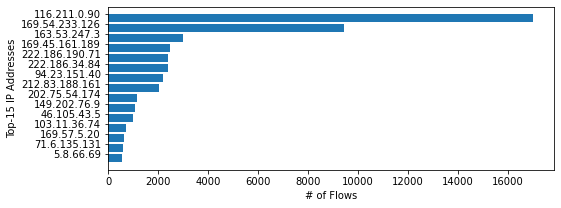

In [6]:
%matplotlib inline
from collections import defaultdict
from plotting import plot_flows
from testing import check_ips_by_flows

def test_internal(ip_str):
    return ip_str.startswith('128.112.')

def count_by_flows(counts, current_flow):
    dst_ip = current_flow['Dst IP addr']
    src_ip = current_flow['Src IP addr']
    if not test_internal(src_ip):
        counts[src_ip] += 1
    if not test_internal(dst_ip):
        counts[dst_ip] += 1
    return counts

ips_by_flows = reduce(count_by_flows, netflow_data, defaultdict(int))

sorted_ips_by_flows = sorted(ips_by_flows.items(), reverse=True, key=lambda x: x[1])
print("Most popular IP addresses by number of flows: {}\n".format(sorted_ips_by_flows[0:5]))

plot_flows(sorted_ips_by_flows)

We can write a similar code to determine popular IP addresses by total volume. Instead of incrementing the dictionary value by `1`, we can update the value by `current_flow['Bytes']`.

Or, similarly, we can write code to determine most popular applications among network users. We would create a dictionary with key containing protocol values (keep only the well-known ports) and the values containing the number of flows or the number of bytes transferred.